# **Reinforcement Learning for E-Commerce : Pick and Place Robot in an E-Commerce Store Warehouse (Q-Learning in Action)**

In [1]:
import numpy as np

# The Problem statement
Let's consider a pick and place robot in an E-Commerce store warehouse. We will give the location of an object, which will also be the starting location of the robot and from there it will find the best path to carry the object to  the packaging area. There are obstacles in the path and there is going to be a penalty (negative reward) if the robot bumps into the obstacle. Also it has to reach the packaging area in minimum amount of time, so there is a very small negative reward for every step it takes. The environment is shown below, in a not so pretty diagram.

# Understanding The Environment

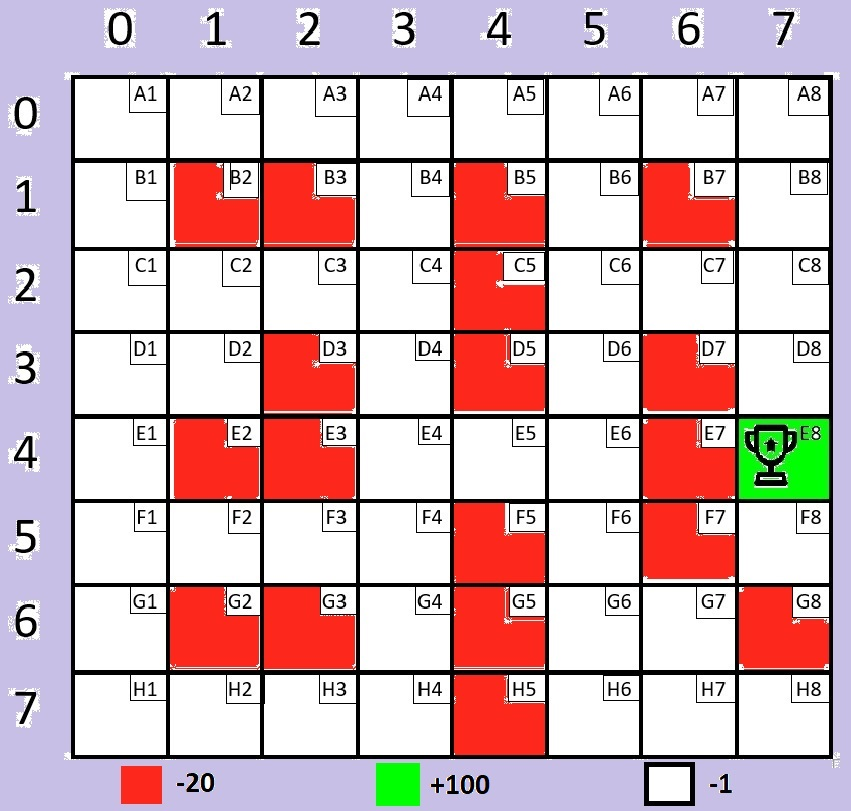



*   The total environment is divided into a grid of 8 by 8. So there are 8 rows and 8 columns.


*   Those rows and columns are indexed from 0 to 7 as shown in the left and top of figure. These indices are also used in the code to help traversing using loops. 

*   But every cell in the grid is also given a code name. These code names are shown in top right corner of every cell. The names start from A1, A2…… A8 for first row and so on. 


*   The red cells are the one’s which are forbidden for the robot. If it bumps into this red area, then there is a rewards of -20 as shown in the bottom.
*   From information given in the bottom, it is also clear that reaching the target at Cell E8 which is at index (4,7) has a reward of 100 (that’s where the packaging area is) and robot is allowed to move along all the white cells which has a reward of -1. 


*   This negative reward of -1 will motivate the robot to hurry up.


# Warehouse Reward map and Variables



*   First we create a numpy array which represents the map of rewards in ware house. So the array element is -1 for white cells, -20 for red cells and 100 for green cells. 

*   Then we define epsilon for Epsilon Greedy Strategy. Then discounting factor, learning rate and number of actions. 

*   Then we create a numpy array which represents the map of rewards in ware house. So the array element is -1 for white cells, -20 for red cells and 100 for green cells. 


*   Then we define epsilon for Epsilon Greedy Strategy. Then discounting factor, learning rate and number of actions. 





In [2]:
# Map of rewards for warehouse
rewardList = [
[-1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
[-1.,  -20.,  -20.,   -1.,  -20.,   -1.,  -20.,   -1.],
[-1.,   -1.,   -1.,   -1.,  -20.,   -1.,   -1.,   -1.],
[-1.,   -1.,  -20.,   -1.,  -20.,   -1.,  -20.,   -1.],
[-1.,  -20.,  -20.,   -1.,   -1.,   -1.,  -20.,  100.],
[-1.,   -1.,   -1.,   -1.,  -20.,   -1.,  -20.,   -1.],
[-1.,  -20.,  -20.,   -1.,  -20.,   -1.,   -1.,  -20.],
[-1.,   -1.,   -1.,   -1.,  -20.,   -1.,   -1.,   -1.]
]
map_rewards=np.array(rewardList)

Declaring Variables

In [3]:
greedy_eps = 0.9   # epsilon
gamma = 0.9       #discounting factor
alpha = 0.9      #learning rate 
actions = ['up', 'right', 'down', 'left']
WHrows = 8     #warehouse rows
WHcols = 8     #warehouse columns
table_Q = np.zeros((WHrows, WHcols, 4))

In [4]:
# A code name for every pair of indices for every grid cell
# The indices are given in tuples
codeNames={}
codeNames[(0,0)]='A1'
codeNames[(0,1)]='A2'
codeNames[(0,2)]='A3'
codeNames[(0,3)]='A4'
codeNames[(0,4)]='A5'
codeNames[(0,5)]='A6'
codeNames[(0,6)]='A7'
codeNames[(0,7)]='A8'

codeNames[(1,0)]='B1'
codeNames[(1,1)]='B2'
codeNames[(1,2)]='B3'
codeNames[(1,3)]='B4'
codeNames[(1,4)]='B5'
codeNames[(1,5)]='B6'
codeNames[(1,6)]='B7'
codeNames[(1,7)]='B8'

codeNames[(2,0)]='C1'
codeNames[(2,1)]='C2'
codeNames[(2,2)]='C3'
codeNames[(2,3)]='C4'
codeNames[(2,4)]='C5'
codeNames[(2,5)]='C6'
codeNames[(2,6)]='C7'
codeNames[(2,7)]='C8'

codeNames[(3,0)]='D1'
codeNames[(3,1)]='D2'
codeNames[(3,2)]='D3'
codeNames[(3,3)]='D4'
codeNames[(3,4)]='D5'
codeNames[(3,5)]='D6'
codeNames[(3,6)]='D7'
codeNames[(3,7)]='D8'

codeNames[(4,0)]='E1'
codeNames[(4,1)]='E2'
codeNames[(4,2)]='E3'
codeNames[(4,3)]='E4'
codeNames[(4,4)]='E5'
codeNames[(4,5)]='E6'
codeNames[(4,6)]='E7'
codeNames[(4,7)]='E8'

codeNames[(5,0)]='F1'
codeNames[(5,1)]='F2'
codeNames[(5,2)]='F3'
codeNames[(5,3)]='F4'
codeNames[(5,4)]='F5'
codeNames[(5,5)]='F6'
codeNames[(5,6)]='F7'
codeNames[(5,7)]='F8'

codeNames[(6,0)]='G1'
codeNames[(6,1)]='G2'
codeNames[(6,2)]='G3'
codeNames[(6,3)]='G4'
codeNames[(6,4)]='G5'
codeNames[(6,5)]='G6'
codeNames[(6,6)]='G7'
codeNames[(6,7)]='G8'

codeNames[(7,0)]='H1'
codeNames[(7,1)]='H2'
codeNames[(7,2)]='H3'
codeNames[(7,3)]='H4'
codeNames[(7,4)]='H5'
codeNames[(7,5)]='H6'
codeNames[(7,6)]='H7'
codeNames[(7,7)]='H8'

# Defining Functions

In [5]:
def get_codeNames_path(shortest_path):
    """
    The reverse mapping from indices of locations to the code names is done.

    Args:
          shortest_path(List) : its a list of tuples containing indices

    
    returns: 
          pathList: List of locations in final path in the form of code names
    """
    pathList = []
    for i in shortest_path:
        j=tuple(i)
#         print(type(j))
        pathList.append(codeNames[j])
        # print(codeNames[j])
    return pathList

In [6]:
def location_next(row, col, action_index):
    """
    Computes the indices of new row and column after taking the action

    Args:
          row(int) : index of row
          col(int) : index of column
          action_index(int): index of action

    
    returns: 
          new_row(int)  : index of new row after taking the action
          new_column(int):index of new column after taking the action
    """
    new_row = row
    new_column = col
    if actions[action_index] == 'up' and row > 0:
        new_row -= 1
    elif actions[action_index] == 'right' and col < WHcols - 1:
        new_column += 1
    elif actions[action_index] == 'down' and row < WHrows - 1:
        new_row += 1
    elif actions[action_index] == 'left' and col > 0:
        new_column -= 1
    return new_row, new_column

In [7]:
def action_next(row, col, greedy_eps):
    """
    Select next action based on Epsilon Greedy Policy

    Args:
          row(int) : index of row
          col(int) : index of column
          greedy_eps: The value of epsilon

    
    returns: 
          Action : The index of next action
    """
    if np.random.random() < greedy_eps:
        return np.argmax(table_Q[row, col])
    else: #choose a random action
        return np.random.randint(4)

In [8]:
def final_path(start_row_index, start_column_index):
    """
    Computes/prints final path of Agent/Robot

    Args:
          start_row_index(int) : index of row of start position of robot
          start_column_index(int) : index of column of start position of robot
    """
    pathList=[]
    if map_rewards[start_row_index, start_column_index] != -1.:
        return []
    else: 
        row, col = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([row, col])
        while not map_rewards[row, col] != -1.:
            action_index = action_next(row, col, 1.)
            row, col = location_next(row, col, action_index) 
            shortest_path.append([row, col])
            pathList=get_codeNames_path(shortest_path)
        for i in pathList:
          if i != pathList[-1]:
            print(i, end =" => ")
          else:
            print(i)
        # return pathList

In [9]:
def start_pos():
    """
    Select starting legal position for each episode randomly

    Args:

    
    returns: 
          row(int) : index of row of start position of robot
          col(int) : index of column of start position of robot
    """
    row = np.random.randint(WHrows)
    col = np.random.randint(WHcols)
    while map_rewards[row, col] != -1.:
        row = np.random.randint(WHrows)
        col = np.random.randint(WHcols)
    return row, col

**Reinforcement Learning**

Then a for loop which runs for 1000 times to train the agent, first gets a starting position for the agent from start_pos( ) function. Then a while loop runs until the agents doesn’t enter into an illegal(red colored) cell. Following steps are performed in the while loop that are essential for Q learning.
1. From current row and column, based on Epsilon Greedy Strategy next action is selected.

2. The current row and columns are saved as old row and columns.

3. The location_next( ) function gives next location based on the selected action

4. Reward is obtained for this selected location.

5. For on action performed in old row and column, the Q value is obtained from the map_rewards numpy array.

6. Using reward obtained in step 4 and Q value of old location obtained in step 5, the temporal difference is calculated. This calculation also requires the value of gamma and the maximum Q value for current position of agent.

7. Using the temporal difference, Q value of old location and alpha, a new Q value is calculated.

8. This new Q value is updated in the Q table.

In [10]:
"""
The details are described in previous cell
"""
for episode in range(1000):
    # Write algorithm for this in words
    row_index, column_index = start_pos()
    while map_rewards[row_index, column_index] == -1.:
        action_index = action_next(row_index, column_index, greedy_eps)

        row_old, column_old = row_index, column_index 
        row_index, column_index = location_next(row_index, column_index, action_index)
    
        reward = map_rewards[row_index, column_index]
        q_old = table_Q[row_old, column_old, action_index]
        #temporal_difference
        TD = reward + (gamma * np.max(table_Q[row_index, column_index])) - q_old
#         print(TD)
        q_new = q_old + (alpha * TD)
        table_Q[row_old, column_old, action_index] = q_new

Following Equation governs the process of training and updates Q tables after every episode

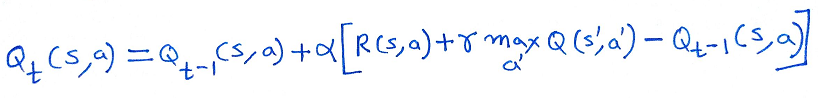

In [11]:
# After training, a sample input is given to get the best path 
# The path is from starting location to packaging area in the warehouse
final_path(3, 3)

D4 => E4 => E5 => E6 => D6 => C6 => C7 => C8 => D8 => E8


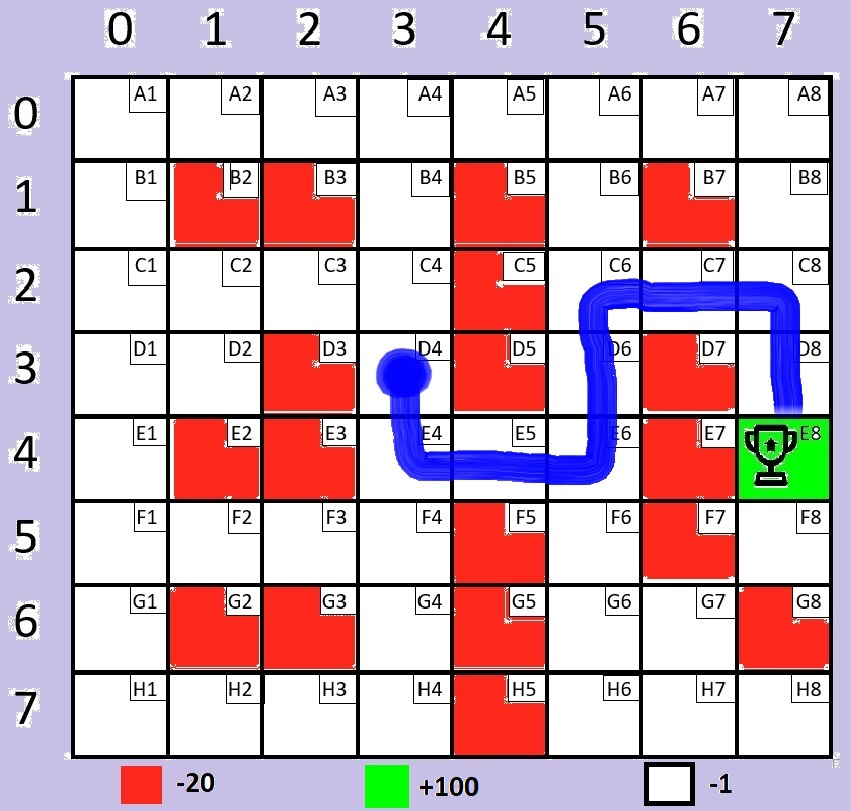

After training, finally when final_path( ) function is called with any starting location for agent that we choose, the final_path( ) function returns, the best path for the agent (pick and place robot in our case). Now that the training is over and its time to get the results, the action_next( ) funtion takes value of 1 for epsilon to exploit the environment. Suitable actions are chosen from the learned Q-table and the best path is returned in the form of series of code names. The reverse mapping from indices of locations to the code names is done by the get_codeNames_path( ) function.
If the input locations of robot is given as (3,3), then it chooses the path as shown in above image. I have drawn this path with blue color on the warehouse map with freehand for demonstration as shown below.

In [12]:
# After training, a sample input is given to get the best path 
# The path is from starting location to packaging area in the warehouse
# The output is drawn with freehand in blue in the next figure
final_path(5, 0)

F1 => F2 => F3 => F4 => E4 => E5 => E6 => D6 => C6 => C7 => C8 => D8 => E8


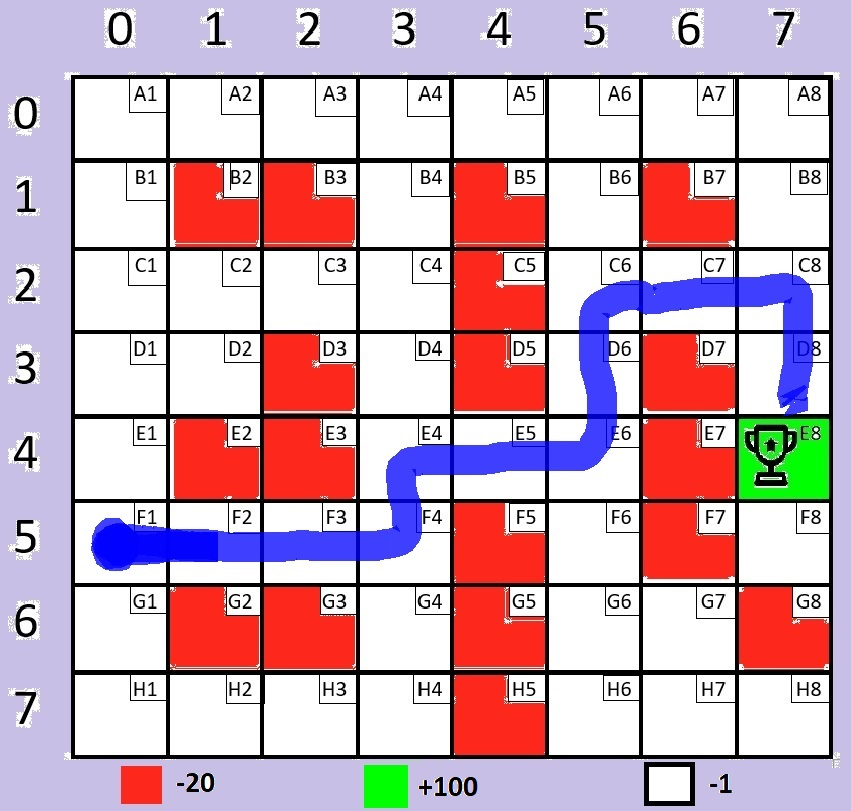

In [13]:
# After training, a sample input is given to get the best path 
# The path is from starting location to packaging area in the warehouse
# The output is drawn with freehand in blue in the next figure
final_path(3, 0)

D1 => C1 => B1 => A1 => A2 => A3 => A4 => A5 => A6 => A7 => A8 => B8 => C8 => D8 => E8


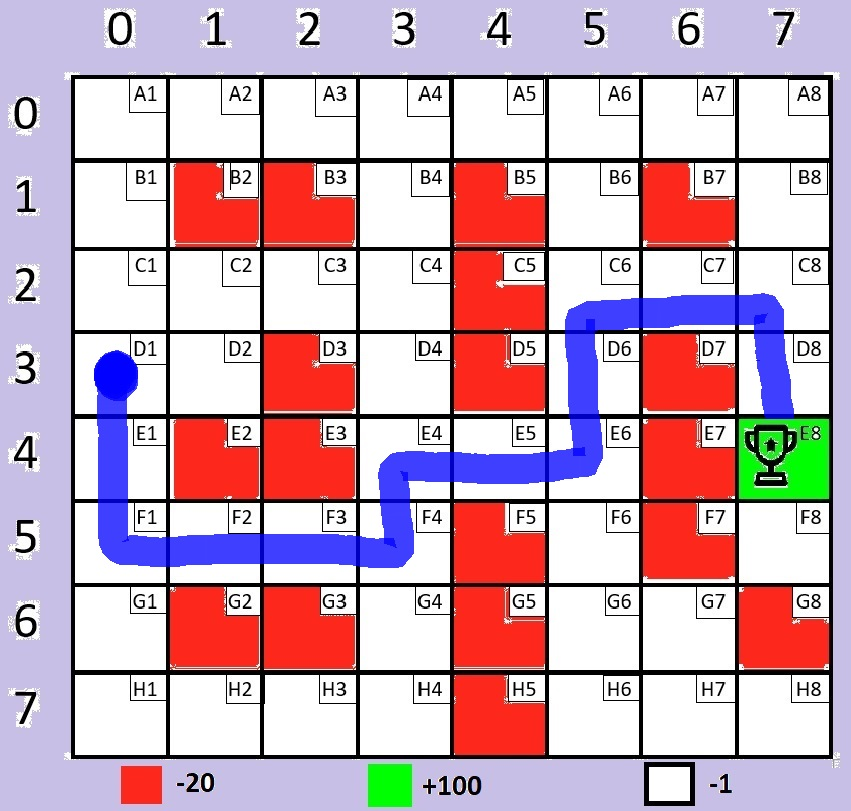

In [14]:
# After training, a sample input is given to get the best path 
# The path is from starting location to packaging area in the warehouse
# The output is drawn with freehand in blue in the next figure
final_path(2, 0)

C1 => B1 => A1 => A2 => A3 => A4 => A5 => A6 => A7 => A8 => B8 => C8 => D8 => E8


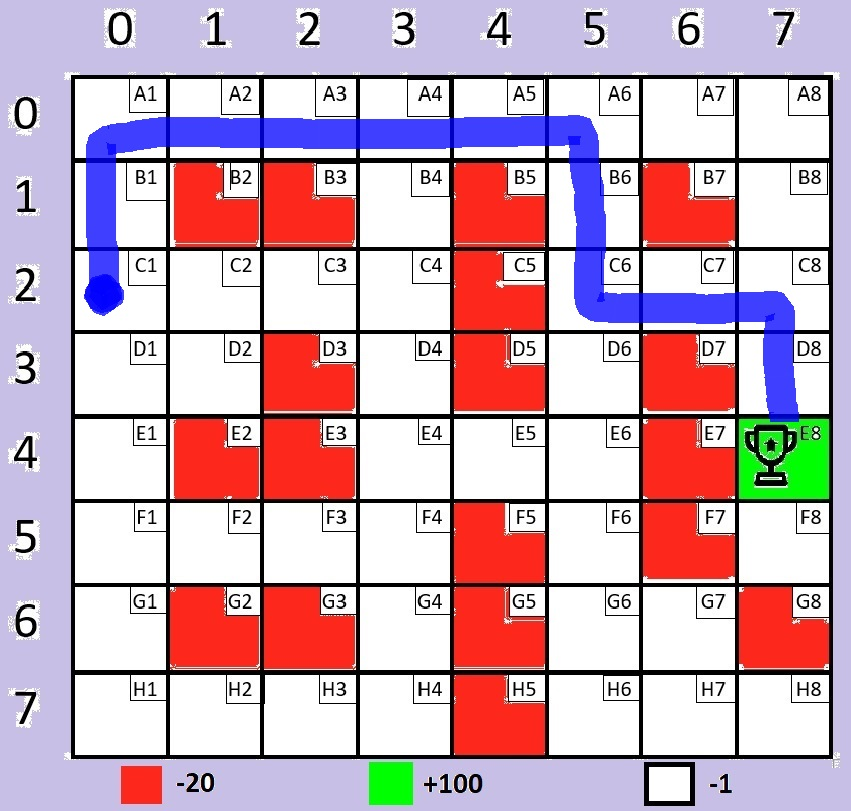